In [1]:
!pip3 install gymnasium[classic_control]
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.7 MB/s eta 0:00:00


In [2]:
!python --version

Python 3.10.12


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from gym.wrappers import TimeLimit


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
# π_θ
class policy_network(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(policy_network, self).__init__()
    self.fc = nn.Sequential(
        nn.Linear(state_dim, 128),
        nn.ReLU(),
        nn.Linear(128, action_dim),
        nn.Softmax(dim=-1)
    )

  def forward(self, state):
    return self.fc(state)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Hyperparameters
num_episodes = 500
learning_rate = 1e-2
gamma = 0.99

In [6]:
env = gym.make("CartPole-v1")
env = TimeLimit(env, max_episode_steps=500)  # Ensure max_episode_steps is set to 500

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = policy_network(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
losses = []
episode_rewards = []


# Training Loop
for episode in range(num_episodes):
    # Reset the environment and initialize variables
    state, info = env.reset()
    log_probs = []
    rewards = []
    done = False
    episode_reward = 0

    # print(f"Starting Episode {episode + 1}")  # Debugging statement

    for t in count():
        # Convert state to tensor and predict action probabilities
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = policy(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        log_probs.append(action_dist.log_prob(action))

        # Take action and observe the outcome
        state, reward, terminated, truncated, *_ = env.step(action.item())
        done = terminated or truncated
        reward = torch.tensor([reward], dtype=torch.float32)
        rewards.append(reward)
        episode_reward += reward.item()

        # print(f"Step {t + 1}: Reward {reward.item()}, Terminated: {terminated}, Truncated: {truncated}, Done: {done}")

        # Check termination
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(episode_reward)
            print(f"Episode {episode + 1} finished after {t + 1} steps with reward {episode_reward}")
            plot_durations()
            break


    # Compute returns
    returns = []
    G = 0
    for reward in reversed(rewards):
        G = reward + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)

    # Normalize returns
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # Compute policy gradient loss
    loss = -torch.sum(torch.stack(log_probs) * returns)
    losses.append(loss.item())

    # Update policy
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Check for early stopping condition: 5 consecutive episodes with score > 475
    if episode_reward >= 475:
        consecutive_high_score += 1
    else:
        consecutive_high_score = 0  # Reset the counter if the score is below 475

    if consecutive_high_score >= 8:
        print(f"Agent achieved a score above 475 for 5 consecutive episodes at episode {episode + 1}")
        break

Agent achieved a score above 475 for 5 consecutive episodes at episode 279


<Figure size 640x480 with 0 Axes>

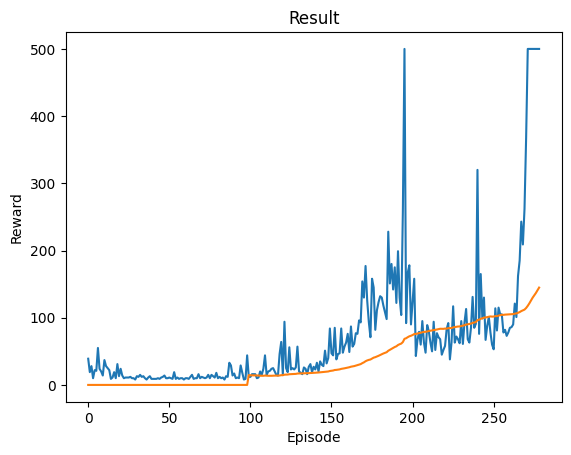

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

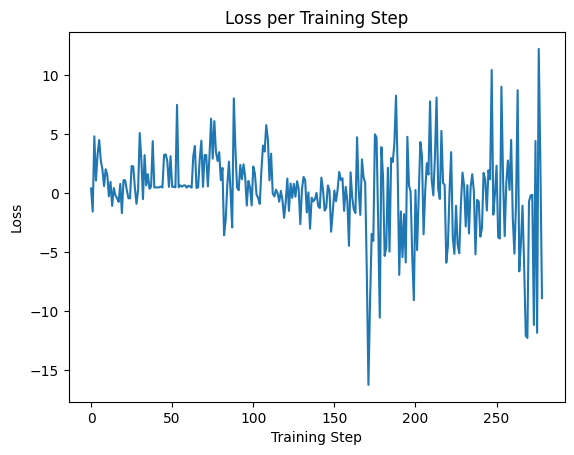

In [10]:
# Plot loss values
plt.figure(3)
plt.title('Loss per Training Step')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()